# Set Up

In [1]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
import torchvision
import json
import os
import shutil
from google.colab.patches import cv2_imshow
import numpy as np
import math
import pickle
from torch.utils.data import random_split, DataLoader
import torch.optim as optim
import torch
import torch.nn as nn

In [3]:
#@title Augementations

train_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.RandomHorizontalFlip(),
    # torchvision.transforms.RandomCrop(32, padding=4),
    torchvision.transforms.ColorJitter(brightness=0.2, contrast=0.2, saturation=0.2, hue=0.1),
    # torchvision.transforms.RandomRotation(15),
    torchvision.transforms.ToTensor(),
   #  torchvision.transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),  # CIFAR-100 normalization values
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])


test_transforms = torchvision.transforms.Compose([
    torchvision.transforms.Resize((224, 224)),
    torchvision.transforms.ToTensor(),
    # torchvision.transforms.Normalize(mean=[0.5071, 0.4867, 0.4408], std=[0.2675, 0.2565, 0.2761]),
    torchvision.transforms.Normalize(mean=[0.5, 0.5, 0.5], std=[0.5, 0.5, 0.5])
])

In [4]:
EXP_NO = 34

EPOCHS = 30
DEVICE = 'cuda' # 'cpu'
LR = 3e-4
DROPOUT = 0.3
MAX_LR = 1e-3
LOSS_WEIGHTS = [1, 0.2, 0.2]
BASE_DIR = f'/content/drive/MyDrive/New Exps/SamplesSiameseH/{EXP_NO}/'

MODEL_NAME = 'mobilenet_v3_small'

DATASET = 'StandfordCars'
AUGMENTATION = False
TRAIN_TRANSFORMS = train_transforms
TEST_TRANSFORMS = test_transforms
SECONDARY_OBJECTIVE = 'all'

BATCH_SIZE = 32
SEED = 24

# Define the loss function and optimizer
criterion = nn.BCELoss() # nn.CrossEntropyLoss()

os.makedirs(os.path.dirname(BASE_DIR), exist_ok=True)

In [5]:
#@title Random Seed

import random

def set_seed(seed: int = 42):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    torch.cuda.manual_seed_all(seed)
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

set_seed(SEED)

In [6]:
#@title Experiment Dictionary

EXPERIMENT_DICTIONARY = {
    'EPOCHS': EPOCHS,
    'DEVICE': DEVICE,
    'EXP_NO': EXP_NO,
    'MODEL': MODEL_NAME,
    'LR': LR,
    'DROPOUT': DROPOUT,
    'LOSS_FUNCTION': str(criterion),
    'OPTIMIZER': str(optim.Adam),
    'MAX_LR': MAX_LR,
    'LOSS_WEIGHTS': LOSS_WEIGHTS,
    'DATASET': DATASET,
    'AUGMENTATION': AUGMENTATION,
    'TRAIN_TRANSFORMS': str(TRAIN_TRANSFORMS),
    'TEST_TRANSFORMS': str(TEST_TRANSFORMS),
    'BATCH_SIZE': BATCH_SIZE,
    'SEED': SEED,
    'SECONDARY_OBJECTIVE': SECONDARY_OBJECTIVE
}

with open(BASE_DIR + "exp_info.json", "w") as outfile:
    json.dump(EXPERIMENT_DICTIONARY, outfile)

In [7]:
#@title Model Choice

if MODEL_NAME == 'mobilenet_v3_small':
  MODEL = torchvision.models.mobilenet_v3_small
elif MODEL_NAME == 'mobilenet_v3_large':
  MODEL = torchvision.models.mobilenet_v3_large
elif MODEL_NAME == 'resnet18':
  MODEL = torchvision.models.resnet18
elif MODEL_NAME == 'resnet50':
  MODEL = torchvision.models.resnet50
elif MODEL_NAME == 'swin_b':
  MODEL = torchvision.models.swin_s
elif MODEL_NAME == 'vgg16':
  MODEL = torchvision.models.vgg16
elif MODEL_NAME == 'vgg19':
  MODEL = torchvision.models.vgg19
elif MODEL_NAME == 'densenet121':
  MODEL = torchvision.models.densenet121
elif MODEL_NAME == 'vit_b_16':
  MODEL = torchvision.models.vit_b_16
elif MODEL_NAME == 'efficientnet_b0':
  MODEL = torchvision.models.efficientnet_b0
elif MODEL_NAME == 'maxvit_t':
  MODEL = torchvision.models.maxvit_t
elif MODEL_NAME == 'convnext_base':
  MODEL = torchvision.models.convnext_base

# Dataset

In [8]:
if not AUGMENTATION:
  TRAIN_TRANSFORMS = TEST_TRANSFORMS

if DATASET == 'StandfordCars':
  !unzip /content/drive/MyDrive/New\ Exps/Dataset/standford_cars.zip -d '/content/dataset/'
  shutil.copy("/content/drive/MyDrive/New Exps/Dataset/cardatasettrain.csv", "/content/dataset/cardatasettrain.csv")
  shutil.copy("/content/drive/MyDrive/New Exps/Dataset/cardatasettest.csv", "/content/dataset/cardatasettest.csv")
  NUM_CLASSES = 196
  NUM_SUPERCLASSES = 49
  NUM_SUBCLASSES = 196
else:
  print(f"{DATASET} dataset nou found.")
  assert False

Streaming output truncated to the last 5000 lines.
  inflating: /content/dataset/cars_train/cars_train/03145.jpg  
  inflating: /content/dataset/cars_train/cars_train/03146.jpg  
  inflating: /content/dataset/cars_train/cars_train/03147.jpg  
  inflating: /content/dataset/cars_train/cars_train/03148.jpg  
  inflating: /content/dataset/cars_train/cars_train/03149.jpg  
  inflating: /content/dataset/cars_train/cars_train/03150.jpg  
  inflating: /content/dataset/cars_train/cars_train/03151.jpg  
  inflating: /content/dataset/cars_train/cars_train/03152.jpg  
  inflating: /content/dataset/cars_train/cars_train/03153.jpg  
  inflating: /content/dataset/cars_train/cars_train/03154.jpg  
  inflating: /content/dataset/cars_train/cars_train/03155.jpg  
  inflating: /content/dataset/cars_train/cars_train/03156.jpg  
  inflating: /content/dataset/cars_train/cars_train/03157.jpg  
  inflating: /content/dataset/cars_train/cars_train/03158.jpg  
  inflating: /content/dataset/cars_train/cars_train/0

In [9]:
#@title Car Type

model_to_car_type = {}
model_to_car_type = {
    "AM General Hummer SUV 2000": "SUV",
    "Acura RL Sedan 2012": "Sedan",
    "Acura TL Sedan 2012": "Sedan",
    "Acura TL Type-S 2008": "Sedan",
    "Acura TSX Sedan 2012": "Sedan",
    "Acura Integra Type R 2001": "Coupe",
    "Acura ZDX Hatchback 2012": "Hatchback",
    "Aston Martin V8 Vantage Convertible 2012": "Convertible",
    "Aston Martin V8 Vantage Coupe 2012": "Coupe",
    "Aston Martin Virage Convertible 2012": "Convertible",
    "Aston Martin Virage Coupe 2012": "Coupe",
    "Audi RS 4 Convertible 2008": "Convertible",
    "Audi A5 Coupe 2012": "Coupe",
    "Audi TTS Coupe 2012": "Coupe",
    "Audi R8 Coupe 2012": "Coupe",
    "Audi V8 Sedan 1994": "Sedan",
    "Audi 100 Sedan 1994": "Sedan",
    "Audi 100 Wagon 1994": "Wagon",
    "Audi TT Hatchback 2011": "Hatchback",
    "Audi S6 Sedan 2011": "Sedan",
    "Audi S5 Convertible 2012": "Convertible",
    "Audi S5 Coupe 2012": "Coupe",
    "Audi S4 Sedan 2012": "Sedan",
    "Audi S4 Sedan 2007": "Sedan",
    "Audi TT RS Coupe 2012": "Coupe",
    "BMW ActiveHybrid 5 Sedan 2012": "Sedan",
    "BMW 1 Series Convertible 2012": "Convertible",
    "BMW 1 Series Coupe 2012": "Coupe",
    "BMW 3 Series Sedan 2012": "Sedan",
    "BMW 3 Series Wagon 2012": "Wagon",
    "BMW 6 Series Convertible 2007": "Convertible",
    "BMW X5 SUV 2007": "SUV",
    "BMW X6 SUV 2012": "SUV",
    "BMW M3 Coupe 2012": "Coupe",
    "BMW M5 Sedan 2010": "Sedan",
    "BMW M6 Convertible 2010": "Convertible",
    "BMW X3 SUV 2012": "SUV",
    "BMW Z4 Convertible 2012": "Convertible",
    "Bentley Continental Supersports Conv. Convertible 2012": "Convertible",
    "Bentley Arnage Sedan 2009": "Sedan",
    "Bentley Mulsanne Sedan 2011": "Sedan",
    "Bentley Continental GT Coupe 2012": "Coupe",
    "Bentley Continental GT Coupe 2007": "Coupe",
    "Bentley Continental Flying Spur Sedan 2007": "Sedan",
    "Bugatti Veyron 16.4 Convertible 2009": "Convertible",
    "Bugatti Veyron 16.4 Coupe 2009": "Coupe",
    "Buick Regal GS 2012": "Sedan",
    "Buick Rainier SUV 2007": "SUV",
    "Buick Verano Sedan 2012": "Sedan",
    "Buick Enclave SUV 2012": "SUV",
    "Cadillac CTS-V Sedan 2012": "Sedan",
    "Cadillac SRX SUV 2012": "SUV",
    "Cadillac Escalade EXT Crew Cab 2007": "Pickup Truck",
    "Chevrolet Silverado 1500 Hybrid Crew Cab 2012": "Pickup Truck",
    "Chevrolet Corvette Convertible 2012": "Convertible",
    "Chevrolet Corvette ZR1 2012": "Coupe",
    "Chevrolet Corvette Ron Fellows Edition Z06 2007": "Coupe",
    "Chevrolet Traverse SUV 2012": "SUV",
    "Chevrolet Camaro Convertible 2012": "Convertible",
    "Chevrolet HHR SS 2010": "Hatchback",
    "Chevrolet Impala Sedan 2007": "Sedan",
    "Chevrolet Tahoe Hybrid SUV 2012": "SUV",
    "Chevrolet Sonic Sedan 2012": "Sedan",
    "Chevrolet Express Cargo Van 2007": "Van",
    "Chevrolet Avalanche Crew Cab 2012": "Pickup Truck",
    "Chevrolet Cobalt SS 2010": "Coupe",
    "Chevrolet Malibu Hybrid Sedan 2010": "Sedan",
    "Chevrolet TrailBlazer SS 2009": "SUV",
    "Chevrolet Silverado 2500HD Regular Cab 2012": "Pickup Truck",
    "Chevrolet Silverado 1500 Classic Extended Cab 2007": "Pickup Truck",
    "Chevrolet Express Van 2007": "Van",
    "Chevrolet Monte Carlo Coupe 2007": "Coupe",
    "Chevrolet Malibu Sedan 2007": "Sedan",
    "Chevrolet Silverado 1500 Extended Cab 2012": "Pickup Truck",
    "Chevrolet Silverado 1500 Regular Cab 2012": "Pickup Truck",
    "Chrysler Aspen SUV 2009": "SUV",
    "Chrysler Sebring Convertible 2010": "Convertible",
    "Chrysler Town and Country Minivan 2012": "Minivan",
    "Chrysler 300 SRT-8 2010": "Sedan",
    "Chrysler Crossfire Convertible 2008": "Convertible",
    "Chrysler PT Cruiser Convertible 2008": "Convertible",
    "Daewoo Nubira Wagon 2002": "Wagon",
    "Dodge Caliber Wagon 2012": "Wagon",
    "Dodge Caliber Wagon 2007": "Wagon",
    "Dodge Caravan Minivan 1997": "Minivan",
    "Dodge Ram Pickup 3500 Crew Cab 2010": "Pickup Truck",
    "Dodge Ram Pickup 3500 Quad Cab 2009": "Pickup Truck",
    "Dodge Sprinter Cargo Van 2009": "Van",
    "Dodge Journey SUV 2012": "SUV",
    "Dodge Dakota Crew Cab 2010": "Pickup Truck",
    "Dodge Dakota Club Cab 2007": "Pickup Truck",
    "Dodge Magnum Wagon 2008": "Wagon",
    "Dodge Challenger SRT8 2011": "Coupe",
    "Dodge Durango SUV 2012": "SUV",
    "Dodge Durango SUV 2007": "SUV",
    "Dodge Charger Sedan 2012": "Sedan",
    "Dodge Charger SRT-8 2009": "Sedan",
    "Eagle Talon Hatchback 1998": "Hatchback",
    "FIAT 500 Abarth 2012": "Hatchback",
    "FIAT 500 Convertible 2012": "Convertible",
    "Ferrari FF Coupe 2012": "Coupe",
    "Ferrari California Convertible 2012": "Convertible",
    "Ferrari 458 Italia Convertible 2012": "Convertible",
    "Ferrari 458 Italia Coupe 2012": "Coupe",
    "Fisker Karma Sedan 2012": "Sedan",
    "Ford F-450 Super Duty Crew Cab 2012": "Pickup Truck",
    "Ford Mustang Convertible 2007": "Convertible",
    "Ford Freestar Minivan 2007": "Minivan",
    "Ford Expedition EL SUV 2009": "SUV",
    "Ford Edge SUV 2012": "SUV",
    "Ford Ranger SuperCab 2011": "Pickup Truck",
    "Ford GT Coupe 2006": "Coupe",
    "Ford F-150 Regular Cab 2012": "Pickup Truck",
    "Ford F-150 Regular Cab 2007": "Pickup Truck",
    "Ford Focus Sedan 2007": "Sedan",
    "Ford E-Series Wagon Van 2012": "Van",
    "Ford Fiesta Sedan 2012": "Sedan",
    "GMC Terrain SUV 2012": "SUV",
    "GMC Savana Van 2012": "Van",
    "GMC Yukon Hybrid SUV 2012": "SUV",
    "GMC Acadia SUV 2012": "SUV",
    "GMC Canyon Extended Cab 2012": "Pickup Truck",
    "Geo Metro Convertible 1993": "Convertible",
    "HUMMER H3T Crew Cab 2010": "Pickup Truck",
    "HUMMER H2 SUT Crew Cab 2009": "Pickup Truck",
    "Honda Odyssey Minivan 2012": "Minivan",
    "Honda Odyssey Minivan 2007": "Minivan",
    "Honda Accord Coupe 2012": "Coupe",
    "Honda Accord Sedan 2012": "Sedan",
    "Hyundai Veloster Hatchback 2012": "Hatchback",
    "Hyundai Santa Fe SUV 2012": "SUV",
    "Hyundai Tucson SUV 2012": "SUV",
    "Hyundai Veracruz SUV 2012": "SUV",
    "Hyundai Sonata Hybrid Sedan 2012": "Sedan",
    "Hyundai Elantra Sedan 2007": "Sedan",
    "Hyundai Accent Sedan 2012": "Sedan",
    "Hyundai Genesis Sedan 2012": "Sedan",
    "Hyundai Sonata Sedan 2012": "Sedan",
    "Hyundai Elantra Touring Hatchback 2012": "Hatchback",
    "Hyundai Azera Sedan 2012": "Sedan"
}
model_to_car_type.update({
    "Infiniti G Coupe IPL 2012": "Coupe",
    "Infiniti QX56 SUV 2011": "SUV",
    "Isuzu Ascender SUV 2008": "SUV",
    "Jaguar XK XKR 2012": "Coupe",
    "Jeep Patriot SUV 2012": "SUV",
    "Jeep Wrangler SUV 2012": "SUV",
    "Jeep Liberty SUV 2012": "SUV",
    "Jeep Grand Cherokee SUV 2012": "SUV",
    "Jeep Compass SUV 2012": "SUV",
    "Lamborghini Reventon Coupe 2008": "Supercar",
    "Lamborghini Aventador Coupe 2012": "Supercar",
    "Lamborghini Gallardo LP 570-4 Superleggera 2012": "Supercar",
    "Lamborghini Diablo Coupe 2001": "Supercar",
    "Land Rover Range Rover SUV 2012": "SUV",
    "Land Rover LR2 SUV 2012": "SUV",
    "Lincoln Town Car Sedan 2011": "Sedan",
    "MINI Cooper Roadster Convertible 2012": "Convertible",
    "Maybach Landaulet Convertible 2012": "Convertible",
    "Mazda Tribute SUV 2011": "SUV",
    "McLaren MP4-12C Coupe 2012": "Supercar",
    "Mercedes-Benz 300-Class Convertible 1993": "Convertible",
    "Mercedes-Benz C-Class Sedan 2012": "Sedan",
    "Mercedes-Benz SL-Class Coupe 2009": "Coupe",
    "Mercedes-Benz E-Class Sedan 2012": "Sedan",
    "Mercedes-Benz S-Class Sedan 2012": "Sedan",
    "Mercedes-Benz Sprinter Van 2012": "Van",
    "Mitsubishi Lancer Sedan 2012": "Sedan",
    "Nissan Leaf Hatchback 2012": "Hatchback",
    "Nissan NV Passenger Van 2012": "Van",
    "Nissan Juke Hatchback 2012": "Hatchback",
    "Nissan 240SX Coupe 1998": "Coupe",
    "Plymouth Neon Coupe 1999": "Coupe",
    "Porsche Panamera Sedan 2012": "Sedan",
    "Ram C/V Cargo Van Minivan 2012": "Minivan",
    "Rolls-Royce Phantom Drophead Coupe Convertible 2012": "Supercar",
    "Rolls-Royce Ghost Sedan 2012": "Sedan",
    "Rolls-Royce Phantom Sedan 2012": "Sedan",
    "Scion xD Hatchback 2012": "Hatchback",
    "Spyker C8 Convertible 2009": "Supercar",
    "Spyker C8 Coupe 2009": "Supercar",
    "Suzuki Aerio Sedan 2007": "Sedan",
    "Suzuki Kizashi Sedan 2012": "Sedan",
    "Suzuki SX4 Hatchback 2012": "Hatchback",
    "Suzuki SX4 Sedan 2012": "Sedan",
    "Tesla Model S Sedan 2012": "Sedan",
    "Toyota Sequoia SUV 2012": "SUV",
    "Toyota Camry Sedan 2012": "Sedan",
    "Toyota Corolla Sedan 2012": "Sedan",
    "Toyota 4Runner SUV 2012": "SUV",
    "Volkswagen Golf Hatchback 2012": "Hatchback",
    "Volkswagen Golf Hatchback 1991": "Hatchback",
    "Volkswagen Beetle Hatchback 2012": "Hatchback",
    "Volvo C30 Hatchback 2012": "Hatchback",
    "Volvo 240 Sedan 1993": "Sedan",
    "Volvo XC90 SUV 2007": "SUV",
    "smart fortwo Convertible 2012": "Convertible"
})

In [10]:
import torch
import random
import pandas as pd
from scipy.io import loadmat
from PIL import Image
from torchvision import transforms
from torch.utils.data import Dataset

class SiameseStanfordCarsDataset(Dataset):
    def __init__(self, root, split, transform=None, target_transform=None, label_mode='same_make', class_to_type_dict=None):
        self.root = root
        self.split = split
        self.transform = transform
        self.target_transform = target_transform
        self.label_mode = label_mode  # 'same_model' or 'same_type'
        self.class_to_type_dict = class_to_type_dict or {}
        # Set path
        self.path = 'cars_train' if self.split in ['train', 'val'] else 'cars_train'
        self.image_paths = f"{self.root}/{self.path}/{self.path}/"
        self.label_path = f"{self.root}/cars_annos.mat"

        # Load annotations
        annotation_path = '/content/dataset/cardatasettrain.csv' # if split in ['train', 'val'] else '/content/dataset/cardatasettest.csv'
        self.annotation_df = pd.read_csv(annotation_path)

        # Data structures
        self.data = []
        self.labels = []
        self.model_to_indices = {}  # {model_id: [indices]}
        self.make_to_indices = {}   # {make: [indices]}
        self.alphabetical_to_original_label = {}

        # Load dataset
        self.load_data()

    def load_data(self):
        data = loadmat(self.label_path)
        self.classes = data['class_names'][0]
        # print(self.classes)
        self.hierarchic_classes = list(set([cls[0].split(' ')[0] for cls in self.classes]))

        no_samples = len(self.annotation_df)
        for idx, sample in self.annotation_df.iterrows():
            image_name = sample['image']
            image_no = int(image_name.split('.')[0])

            # Train/Val/Test Split
            if (self.split == 'train' and idx <= int(no_samples * 0.7)) or \
               (self.split == 'val' and int(no_samples * 0.7) < idx <= int(no_samples * 0.9)) or \
               (self.split == 'test' and idx > int(no_samples * 0.9)):

                image_name = str(image_no).zfill(5) + '.jpg'
                image_path = self.image_paths + image_name
                class_id = sample['Class'] - 1

                # Determine car make (superclass)
                superclass = self.classes[class_id][0].split(' ')[0]
                super_index = self.hierarchic_classes.index(superclass)

                # Store label mappings
                if class_id not in self.alphabetical_to_original_label:
                    self.alphabetical_to_original_label[class_id] = {
                        'index': class_id,
                        'class': self.classes[class_id],
                        'super_index': super_index,
                        'superclass': superclass
                    }

                # Group images by model
                relative_idx = idx
                if self.split == 'val':
                  relative_idx = idx - int(no_samples * 0.7) - 1
                if self.split == 'test':
                  relative_idx = idx - int(no_samples * 0.9) - 1
                if class_id not in self.model_to_indices:
                    self.model_to_indices[class_id] = [relative_idx]
                self.model_to_indices[class_id].append(relative_idx)

                # Group images by make
                if superclass not in self.make_to_indices:
                    self.make_to_indices[superclass] = [relative_idx]
                self.make_to_indices[superclass].append(relative_idx)

                # Store image data
                self.data.append(image_path)
                self.labels.append(class_id)

    def __len__(self):
        return len(self.data)

    def __getitem__(self, idx):
        # Load first image
        img1 = Image.open(self.data[idx]).convert("RGB")
        label1 = self.labels[idx]
        make1 = self.alphabetical_to_original_label[label1]['superclass']
        type1 = self.class_to_type_dict[self.classes[label1][0]] # self.class_to_type_dict.get(label1, "Unknown")

        # Decide if we want a positive (same model/type) or negative
        random_choice = random.random()
        if random_choice >= 0.5:
            img2_idx = random.choice(self.model_to_indices[label1])
        else:
            different_models = list(self.model_to_indices.keys())
            different_models.remove(label1)
            new_model = random.choice(different_models)
            img2_idx = random.choice(self.model_to_indices[new_model])

        # Load second image
        img2 = Image.open(self.data[img2_idx]).convert("RGB")
        label2 = self.labels[img2_idx]
        make2 = self.alphabetical_to_original_label[label2]['superclass']
        type2 = self.class_to_type_dict[self.classes[label2][0]] # self.class_to_type_dict.get(label2, "Unknown")

        # Compute labels
        same_model = 1 if label1 == label2 else 0
        same_type = 1 if type1 == type2 else 0
        same_make = 1 if make1 == make2 else 0


        secondary_target = torch.tensor(same_make, dtype=torch.float32)
        third_target = torch.tensor(same_type, dtype=torch.float32)

        target = torch.tensor(same_model, dtype=torch.float32)

        # Apply transformations
        if self.transform:
            img1 = self.transform(img1)
            img2 = self.transform(img2)

        return img1, img2, target, secondary_target, third_target

if DATASET == 'StandfordCars':
    train_dataset = SiameseStanfordCarsDataset(root='/content/dataset', split='train', transform=TRAIN_TRANSFORMS, label_mode=SECONDARY_OBJECTIVE, class_to_type_dict=model_to_car_type)
    alphabetical_to_original_label = train_dataset.alphabetical_to_original_label
    val_dataset = SiameseStanfordCarsDataset(root='/content/dataset', split='val', transform=TEST_TRANSFORMS, label_mode=SECONDARY_OBJECTIVE, class_to_type_dict=model_to_car_type)
    test_dataset = SiameseStanfordCarsDataset(root='/content/dataset', split='test', transform=TEST_TRANSFORMS, label_mode=SECONDARY_OBJECTIVE, class_to_type_dict=model_to_car_type)
    train_loader_classic  = DataLoader(train_dataset, batch_size=64, shuffle=True)
    val_loader_clasic = DataLoader(val_dataset, batch_size=64, shuffle=False)
    test_loader_clasic = DataLoader(test_dataset, batch_size=64, shuffle=False)

# Model

In [11]:
#@title Classic Siamese Model

class ClassicMobileNetV3(nn.Module):
    def __init__(self, num_classes=100, pretrained=True, dropout_p=0.5):
        super(ClassicMobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 model from torchvision
        self.mobilenet = MODEL(pretrained=pretrained)

        if 'mobilenet_v3' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Identity()
        elif 'resnet' in MODEL_NAME:
          in_features = self.mobilenet.fc.in_features
          self.mobilenet.fc = nn.Identity()
        elif 'swin' in MODEL_NAME:
          in_features = self.mobilenet.head.in_features
          self.mobilenet.head = nn.Identity()
        elif 'vit_b_16' in MODEL_NAME:
          in_features = self.mobilenet.heads.head.in_features
          self.mobilenet.heads.head = nn.Identity()
        elif 'vgg' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Identity()
        elif 'densenet' in MODEL_NAME:
          in_features = self.mobilenet.classifier.in_features
          self.mobilenet.classifier = nn.Identity()
        elif 'efficientnet' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Identity()
        elif 'maxvit' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Identity()
        elif 'convnext' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Identity()
        else:
          assert False

        self.fc = nn.Sequential(
            nn.Linear(in_features * 2, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        feat1 = self.mobilenet(img1)
        feat2 = self.mobilenet(img2)
        combined = torch.cat((feat1, feat2), dim=1)
        similarity = self.fc(combined)
        return similarity, similarity, similarity

classic_model = ClassicMobileNetV3(num_classes=NUM_CLASSES, pretrained=True, dropout_p = DROPOUT)
# Test with dummy data
img1 = torch.randn(1, 3, 224, 224)
img2 = torch.randn(1, 3, 224, 224)
output1, output2, output3 = classic_model(img1, img2)
print(f"Similarity Score: {output1.item():.4f}")

/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/usr/local/lib/python3.11/dist-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=MobileNet_V3_Small_Weights.IMAGENET1K_V1`. You can also use `weights=MobileNet_V3_Small_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)
Downloading: "https://download.pytorch.org/models/mobilenet_v3_small-047dcff4.pth" to /root/.cache/torch/hub/checkpoints/mobilenet_v3_small-047dcff4.pth
100%|██████████| 9.83M/9.83M [00:00<00:00, 89.2MB/s]


Similarity Score: 0.5136


In [12]:
#@title Parallel MT Hierarchical

class Identity(nn.Module):
    def __init__(self):
        super(Identity, self).__init__()

    def forward(self, x):
        return x


class ParallelMultiTaskSiameseMobileNetV3(nn.Module):
    def __init__(self, num_superclasses=20, num_subclasses=100, pretrained=True, dropout_p=0.5):
        super(ParallelMultiTaskSiameseMobileNetV3, self).__init__()
        self.mobilenet = MODEL(pretrained=pretrained)

        if 'mobilenet_v3' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Dropout(p=dropout_p)
        elif 'resnet' in MODEL_NAME:
          in_features = self.mobilenet.fc.in_features
          self.mobilenet.fc = nn.Dropout(p=dropout_p)
        elif 'swin' in MODEL_NAME:
          in_features = self.mobilenet.head.in_features
          self.mobilenet.head = nn.Dropout(p=dropout_p)
        elif 'vit_b_16' in MODEL_NAME:
          in_features = self.mobilenet.heads.head.in_features
          self.mobilenet.heads.head = nn.Dropout(p=dropout_p)
        elif 'vgg' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Dropout(p=dropout_p)
        elif 'densenet' in MODEL_NAME:
          in_features = self.mobilenet.classifier.in_features
          self.mobilenet.classifier = nn.Dropout(p=dropout_p)
        elif 'efficientnet' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Dropout(p=dropout_p)
        elif 'maxvit' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Dropout(p=dropout_p)
        elif 'convnext' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Dropout(p=dropout_p)

        self.fc_model_similarity = nn.Sequential(
            nn.Linear(in_features * 2, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        self.fc_car_type_similarity = nn.Sequential(
            nn.Linear(in_features * 2, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

        self.fc_make_similarity = nn.Sequential(
            nn.Linear(in_features * 2, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 1),
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        # Extract features from both images
        feat1 = self.mobilenet(img1)
        feat2 = self.mobilenet(img2)

        # Concatenate features
        combined = torch.cat((feat1, feat2), dim=1)

        # Compute similarities
        model_similarity = self.fc_model_similarity(combined)
        make_similarity = self.fc_make_similarity(combined)
        car_type_similarity = self.fc_car_type_similarity(combined)

        return model_similarity, make_similarity, car_type_similarity

parallel_model = ParallelMultiTaskSiameseMobileNetV3(num_superclasses=NUM_SUPERCLASSES, num_subclasses=NUM_SUBCLASSES, pretrained=True, dropout_p = DROPOUT)
img1 = torch.randn(1, 3, 224, 224)
img2 = torch.randn(1, 3, 224, 224)
same_model, same_make, same_type = parallel_model(img1, img2)

print(f"Model Similarity: {same_model.item():.4f}")
print(f"Make Similarity: {same_make.item():.4f}")
print(f"Type Similarity: {same_type.item():.4f}")

Model Similarity: 0.4912
Make Similarity: 0.4758
Type Similarity: 0.4991


In [13]:
#@title Cascaded MT Hierarchical

class CascadedSiameseMultiTaskMobileNetV3(nn.Module):
    def __init__(self, num_superclasses=20, num_subclasses=100, pretrained=True, dropout_p=0.5):
        super(CascadedSiameseMultiTaskMobileNetV3, self).__init__()

        # Load the pre-trained MobileNetV3 model from torchvision
        self.mobilenet = MODEL(pretrained=pretrained)


        if 'mobilenet_v3' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Dropout(p=dropout_p)

        elif 'resnet' in MODEL_NAME:
          in_features = self.mobilenet.fc.in_features
          self.mobilenet.fc = nn.Dropout(p=dropout_p)

        elif 'swin' in MODEL_NAME:
          in_features = self.mobilenet.head.in_features
          self.mobilenet.head = nn.Dropout(p=dropout_p)

        elif 'vit_b_16' in MODEL_NAME:
          in_features = self.mobilenet.heads.head.in_features
          self.mobilenet.heads.head = nn.Dropout(p=dropout_p)

        elif 'vgg' in MODEL_NAME:
          # ? Redundant path
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Dropout(p=dropout_p)

        elif 'densenet' in MODEL_NAME:
          in_features = self.mobilenet.classifier.in_features
          self.mobilenet.classifier = nn.Dropout(p=dropout_p)

        elif 'efficientnet' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Dropout(p=dropout_p)

        elif 'maxvit' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Dropout(p=dropout_p)

        elif 'convnext' in MODEL_NAME:
          in_features = self.mobilenet.classifier[-1].in_features
          self.mobilenet.classifier[-1] = nn.Dropout(p=dropout_p)

        self.model_similarity_fc = nn.Sequential(
            nn.Linear(in_features * 2, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 1),  # Binary output (same/different model)
            nn.Sigmoid()
        )

        self.type_similarity_fc = nn.Sequential(
            nn.Linear(in_features * 2, 512),
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 1),  # Binary output (same/different model)
            nn.Sigmoid()
        )

        self.make_similarity_fc = nn.Sequential(
            nn.Linear(in_features * 2 + 2, 512),  # Includes model similarity output
            nn.ReLU(),
            nn.Dropout(p=dropout_p),
            nn.Linear(512, 1),  # Binary output (same/different make)
            nn.Sigmoid()
        )

    def forward(self, img1, img2):
        # Extract features for both images
        feat1 = self.mobilenet(img1)
        feat2 = self.mobilenet(img2)

        # Concatenate features
        combined_features = torch.cat((feat1, feat2), dim=1)
        model_similarity = self.model_similarity_fc(combined_features)
        type_similarity = self.type_similarity_fc(combined_features)
        cascaded_input = torch.cat((combined_features, model_similarity), dim=1)
        cascaded_input = torch.cat((cascaded_input, type_similarity), dim=1)
        make_similarity = self.make_similarity_fc(cascaded_input)

        return model_similarity, make_similarity, type_similarity

model = CascadedSiameseMultiTaskMobileNetV3(pretrained=True, dropout_p=0.5)
img1 = torch.randn(1, 3, 224, 224)
img2 = torch.randn(1, 3, 224, 224)
same_model, same_make, same_type = model(img1, img2)
print(f"Model Similarity: {same_model.item():.4f}")
print(f"Make Similarity: {same_make.item():.4f}")

Model Similarity: 0.5404
Make Similarity: 0.4906


# Training Procedures

In [14]:
#@title Classic Training

import torch
import copy
from torch.optim.lr_scheduler import OneCycleLR

def train_siamese_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda', max_lr=1e-3, phases=['train', 'val']):
    model = model.to(device)
    history = {
        'train_loss': [], 'train_model_acc': [], 'train_make_acc': [], 'train_type_acc': [],
        'val_loss': [], 'val_model_acc': [], 'val_make_acc': [], 'val_type_acc': [],
        'test_loss': [], 'test_model_acc': [], 'test_make_acc': [], 'test_type_acc': []
    }

    # Calculate total steps for 1CycleLR
    total_steps = len(dataloaders['train']) * num_epochs

    # Initialize the 1CycleLR scheduler
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(dataloaders['train']), epochs=num_epochs)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_correct_model = 0
            running_correct_make = 0
            running_correct_type = 0
            total_samples = 0

            for img1, img2, same_model, same_make, same_type in dataloaders[phase]:
                img1, img2, same_model, same_make, same_type = (
                    img1.to(device), img2.to(device),
                    same_model.to(device), same_make.to(device), same_type.to(device)
                )

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    pred_model, pred_make, pred_type = model(img1, img2)

                    # Compute loss
                    loss_model = criterion(pred_model.squeeze(), same_model)
                    # loss_make = criterion(pred_make.squeeze(), same_make)
                    loss = loss_model # + loss_make  # Combined loss

                    # Compute predictions
                    pred_model_binary = (pred_model > 0.5).float().squeeze()
                    pred_make_binary = (pred_make > 0.5).float().squeeze()
                    pred_type_binary = (pred_type > 0.5).float().squeeze()
                    # print(pred_model_binary[:32])
                    # print(same_model[:32])

                    if phase == 'train':
                        loss.backward()
                        optimizer.step()
                        scheduler.step()  # Update LR based on 1Cycle policy

                # Track performance
                running_loss += loss.item() * img1.size(0)
                running_correct_model += torch.sum(pred_model_binary == same_model).item()
                running_correct_make += torch.sum(pred_make_binary == same_make).item()
                running_correct_type += torch.sum(pred_type_binary == same_type).item()
                total_samples += img1.size(0)

            # Compute epoch loss and accuracy
            epoch_loss = running_loss / total_samples
            epoch_model_acc = running_correct_model / total_samples
            epoch_make_acc = running_correct_make / total_samples
            epoch_type_acc = running_correct_type / total_samples

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_model_acc'].append(epoch_model_acc)
            history[f'{phase}_make_acc'].append(epoch_make_acc)
            history[f'{phase}_type_acc'].append(epoch_type_acc)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} | Model Acc: {epoch_model_acc:.4f} | Make Acc: {epoch_make_acc:.4f}')

            # Save the best model based on validation loss
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                model_save_path = BASE_DIR + 'classic_model_best.pt'
                torch.save(model.state_dict(), model_save_path)
                print(f'New best model saved with validation loss: {best_val_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

In [15]:
#@title Parallel Training

import torch
import copy
from torch.optim.lr_scheduler import OneCycleLR

def train_parallel_siamese_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda', max_lr=1e-3, phases=['train', 'val']):
    model = model.to(device)
    history = {
        'train_loss': [], 'train_model_acc': [], 'train_make_acc': [], 'train_type_acc': [],
        'val_loss': [], 'val_model_acc': [], 'val_make_acc': [], 'val_type_acc': [],
        'test_loss': [], 'test_model_acc': [], 'test_make_acc': [], 'test_type_acc': []
    }

    # Calculate total steps for 1CycleLR
    total_steps = len(dataloaders['train']) * num_epochs

    # Initialize the 1CycleLR scheduler
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(dataloaders['train']), epochs=num_epochs)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_correct_model = 0
            running_correct_make = 0
            running_correct_type = 0
            total_samples = 0

            for img1, img2, same_model, same_make, same_type in dataloaders[phase]:
                img1, img2, same_model, same_make, same_type = (
                    img1.to(device), img2.to(device),
                    same_model.to(device), same_make.to(device), same_type.to(device)
                )

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    pred_model, pred_make, pred_type = model(img1, img2)

                    # Compute loss with cascading effect
                    loss_model = criterion(pred_model.squeeze(), same_model) * LOSS_WEIGHTS[0]
                    loss_make = criterion(pred_make.squeeze(), same_make) * LOSS_WEIGHTS[1]
                    loss_type = criterion(pred_type.squeeze(), same_type) * LOSS_WEIGHTS[2]
                    loss = loss_model + loss_make + loss_type

                    # Compute predictions
                    pred_model_binary = (pred_model > 0.5).float().squeeze()
                    pred_make_binary = (pred_make > 0.5).float().squeeze()
                    pred_type_binary = (pred_type > 0.5).float().squeeze()

                    if phase == 'train':
                        loss_model.backward(retain_graph=True)  # Cascade dependencies
                        loss_make.backward()
                        optimizer.step()
                        scheduler.step()  # Update learning rate based on 1Cycle policy

                # Track performance
                running_loss += loss.item() * img1.size(0)
                running_correct_model += torch.sum(pred_model_binary == same_model).item()
                running_correct_make += torch.sum(pred_make_binary == same_make).item()
                running_correct_type += torch.sum(pred_type_binary == same_type).item()
                # total_samples += img1.size(0)

            # Compute epoch loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_model_acc = running_correct_model / len(dataloaders[phase].dataset)
            epoch_make_acc = running_correct_make / len(dataloaders[phase].dataset)
            epoch_type_acc = running_correct_type / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_model_acc'].append(epoch_model_acc)
            history[f'{phase}_make_acc'].append(epoch_make_acc)
            history[f'{phase}_type_acc'].append(epoch_type_acc)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} | Model Acc: {epoch_model_acc:.4f} | Make Acc: {epoch_make_acc:.4f} | Type Acc: {epoch_type_acc:.4f}')

            # Save the best model based on validation loss
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                model_save_path = 'parallel_siamese_model_best.pt'
                torch.save(model.state_dict(), BASE_DIR + model_save_path)
                print(f'New best model saved with validation loss: {best_val_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history


In [16]:
#@title Cascaded Training

import torch
import copy
from torch.optim.lr_scheduler import OneCycleLR

def train_cascaded_siamese_mobilenet(model, dataloaders, criterion, optimizer, num_epochs=25, device='cuda', max_lr=1e-3, phases=['train', 'val']):
    model = model.to(device)
    history = {
        'train_loss': [], 'train_model_acc': [], 'train_make_acc': [], 'train_type_acc': [],
        'val_loss': [], 'val_model_acc': [], 'val_make_acc': [], 'val_type_acc': [],
        'test_loss': [], 'test_model_acc': [], 'test_make_acc': [], 'test_type_acc': []
    }

    # Calculate total steps for 1CycleLR
    total_steps = len(dataloaders['train']) * num_epochs

    # Initialize the 1CycleLR scheduler
    scheduler = OneCycleLR(optimizer, max_lr=max_lr, steps_per_epoch=len(dataloaders['train']), epochs=num_epochs)

    best_model_wts = copy.deepcopy(model.state_dict())
    best_val_loss = float('inf')

    for epoch in range(num_epochs):
        print(f'Epoch {epoch+1}/{num_epochs}')
        print('-' * 10)

        for phase in phases:
            if phase == 'train':
                model.train()
            else:
                model.eval()

            running_loss = 0.0
            running_correct_model = 0
            running_correct_make = 0
            running_correct_type = 0
            total_samples = 0

            for img1, img2, same_model, same_make, same_type in dataloaders[phase]:
                img1, img2, same_model, same_make, same_type = (
                    img1.to(device), img2.to(device),
                    same_model.to(device), same_make.to(device), same_type.to(device)
                )

                optimizer.zero_grad()

                with torch.set_grad_enabled(phase == 'train'):
                    pred_model, pred_make, pred_type = model(img1, img2)

                    # Compute loss with cascading effect
                    loss_model = criterion(pred_model.squeeze(), same_model) * LOSS_WEIGHTS[0]
                    loss_make = criterion(pred_make.squeeze(), same_make) * LOSS_WEIGHTS[1]
                    loss_type = criterion(pred_type.squeeze(), same_type) * LOSS_WEIGHTS[2]
                    loss = loss_model + loss_make + loss_type

                    # Compute predictions
                    pred_model_binary = (pred_model > 0.5).float().squeeze()
                    pred_make_binary = (pred_make > 0.5).float().squeeze()
                    pred_type_binary = (pred_type > 0.5).float().squeeze()

                    if phase == 'train':
                        loss_model.backward(retain_graph=True)  # Cascade dependencies
                        loss_make.backward()
                        optimizer.step()
                        scheduler.step()  # Update learning rate based on 1Cycle policy

                # Track performance
                running_loss += loss.item() * img1.size(0)
                running_correct_model += torch.sum(pred_model_binary == same_model).item()
                running_correct_make += torch.sum(pred_make_binary == same_make).item()
                running_correct_type += torch.sum(pred_type_binary == same_type).item()
                # total_samples += img1.size(0)

            # Compute epoch loss and accuracy
            epoch_loss = running_loss / len(dataloaders[phase].dataset)
            epoch_model_acc = running_correct_model / len(dataloaders[phase].dataset)
            epoch_make_acc = running_correct_make / len(dataloaders[phase].dataset)
            epoch_type_acc = running_correct_type / len(dataloaders[phase].dataset)

            history[f'{phase}_loss'].append(epoch_loss)
            history[f'{phase}_model_acc'].append(epoch_model_acc)
            history[f'{phase}_make_acc'].append(epoch_make_acc)
            history[f'{phase}_type_acc'].append(epoch_type_acc)

            print(f'{phase.capitalize()} Loss: {epoch_loss:.4f} | Model Acc: {epoch_model_acc:.4f} | Make Acc: {epoch_make_acc:.4f} | Type Acc: {epoch_type_acc:.4f}')

            # Save the best model based on validation loss
            if phase == 'val' and epoch_loss < best_val_loss:
                best_val_loss = epoch_loss
                best_model_wts = copy.deepcopy(model.state_dict())
                model_save_path = 'cascaded_siamese_model_best.pt'
                torch.save(model.state_dict(), BASE_DIR + model_save_path)
                print(f'New best model saved with validation loss: {best_val_loss:.4f}')

    # Load best model weights
    model.load_state_dict(best_model_wts)

    return model, history

# Train

In [17]:
# Initialize the model
classic_model = ClassicMobileNetV3(num_classes=NUM_CLASSES, pretrained=True)

# Define the loss function and optimizer
optimizer = optim.Adam(classic_model.parameters(), lr=LR)

# Call the training function for ClassicMobileNetV3
trained_classic_model, classic_history = train_siamese_mobilenet(
    model=classic_model,
    dataloaders={'train': train_loader_classic, 'val': val_loader_clasic, 'test':test_loader_clasic},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE  # or 'cpu' if you don't have a GPU
)

Epoch 1/30
----------
Train Loss: 0.6967 | Model Acc: 0.4975 | Make Acc: 0.5008
Val Loss: 0.6919 | Model Acc: 0.5273 | Make Acc: 0.5292
New best model saved with validation loss: 0.6919
Epoch 2/30
----------
Train Loss: 0.6949 | Model Acc: 0.5138 | Make Acc: 0.5153
Val Loss: 0.6919 | Model Acc: 0.5157 | Make Acc: 0.5163
Epoch 3/30
----------
Train Loss: 0.6959 | Model Acc: 0.5078 | Make Acc: 0.5115
Val Loss: 0.6935 | Model Acc: 0.5021 | Make Acc: 0.4929
Epoch 4/30
----------
Train Loss: 0.6882 | Model Acc: 0.5436 | Make Acc: 0.5383
Val Loss: 0.6653 | Model Acc: 0.5820 | Make Acc: 0.5838
New best model saved with validation loss: 0.6653
Epoch 5/30
----------
Train Loss: 0.6221 | Model Acc: 0.6373 | Make Acc: 0.6378
Val Loss: 0.5775 | Model Acc: 0.6820 | Make Acc: 0.6869
New best model saved with validation loss: 0.5775
Epoch 6/30
----------
Train Loss: 0.5842 | Model Acc: 0.6769 | Make Acc: 0.6790
Val Loss: 0.5383 | Model Acc: 0.7287 | Make Acc: 0.7293
New best model saved with validati

In [18]:
parallel_model = ParallelMultiTaskSiameseMobileNetV3(num_superclasses=NUM_SUPERCLASSES, num_subclasses=NUM_SUBCLASSES, pretrained=True)
optimizer = optim.Adam(parallel_model.parameters(), lr=LR)

# Call the training function for ParallelMultiTaskMobileNetV3
trained_parallel_model, parallel_history = train_parallel_siamese_mobilenet(
    model=parallel_model,
    dataloaders={'train': train_loader_classic, 'val': val_loader_clasic, 'test':test_loader_clasic},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE  # or 'cpu' if you don't have a GPU
)

Epoch 1/30
----------
Train Loss: 0.9787 | Model Acc: 0.4957 | Make Acc: 0.5152 | Type Acc: 0.5238
Val Loss: 0.9750 | Model Acc: 0.4850 | Make Acc: 0.5150 | Type Acc: 0.5003
New best model saved with validation loss: 0.9750
Epoch 2/30
----------
Train Loss: 0.9775 | Model Acc: 0.5078 | Make Acc: 0.4983 | Type Acc: 0.5231
Val Loss: 0.9732 | Model Acc: 0.4788 | Make Acc: 0.5028 | Type Acc: 0.5138
New best model saved with validation loss: 0.9732
Epoch 3/30
----------
Train Loss: 0.9772 | Model Acc: 0.5073 | Make Acc: 0.5187 | Type Acc: 0.5192
Val Loss: 0.9691 | Model Acc: 0.5224 | Make Acc: 0.4997 | Type Acc: 0.5341
New best model saved with validation loss: 0.9691
Epoch 4/30
----------
Train Loss: 0.9799 | Model Acc: 0.5066 | Make Acc: 0.5064 | Type Acc: 0.5331
Val Loss: 0.9743 | Model Acc: 0.5058 | Make Acc: 0.4862 | Type Acc: 0.5335
Epoch 5/30
----------
Train Loss: 0.9717 | Model Acc: 0.5168 | Make Acc: 0.5248 | Type Acc: 0.5296
Val Loss: 0.9704 | Model Acc: 0.5347 | Make Acc: 0.5451

In [ ]:
cascaded_model = CascadedSiameseMultiTaskMobileNetV3(num_superclasses=NUM_SUPERCLASSES, num_subclasses=NUM_SUBCLASSES, pretrained=True)
optimizer = optim.Adam(cascaded_model.parameters(), lr=LR)

trained_cascaded_model, cascaded_history = train_cascaded_siamese_mobilenet(
    model=cascaded_model,
    dataloaders={'train': train_loader_classic, 'val': val_loader_clasic, 'test':test_loader_clasic},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=EPOCHS,
    device=DEVICE  # or 'cpu' if you don't have a GPU
)

Epoch 1/30
----------


# Plot

<ipython-input-20-0b0fea95beff>:28: UserWarning: No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.
  plt.legend(loc='best')


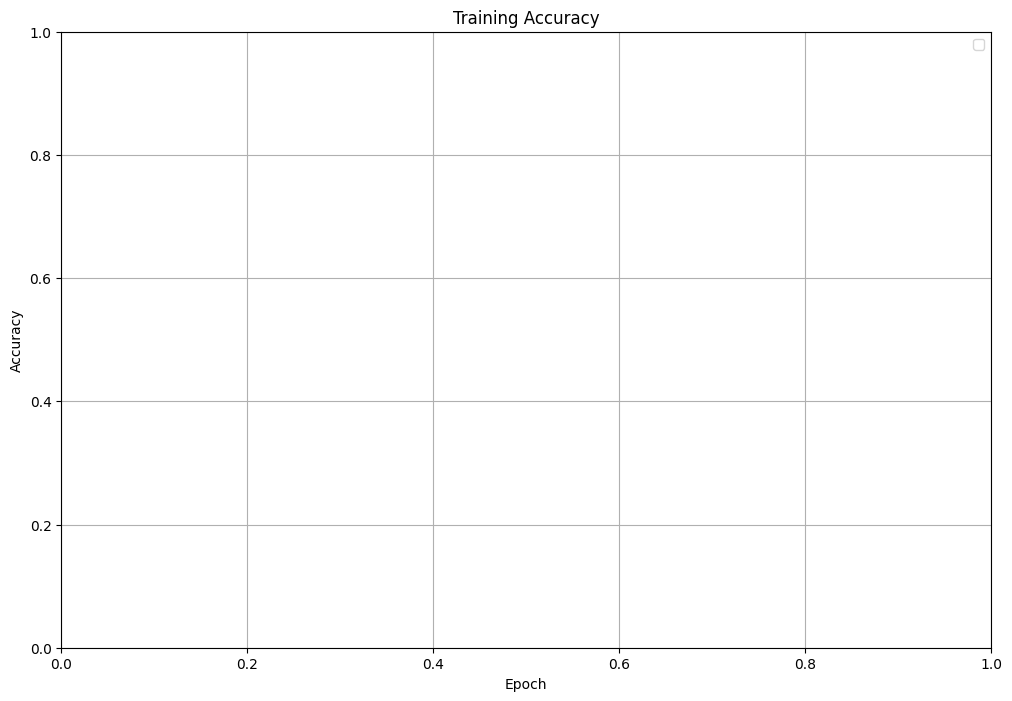

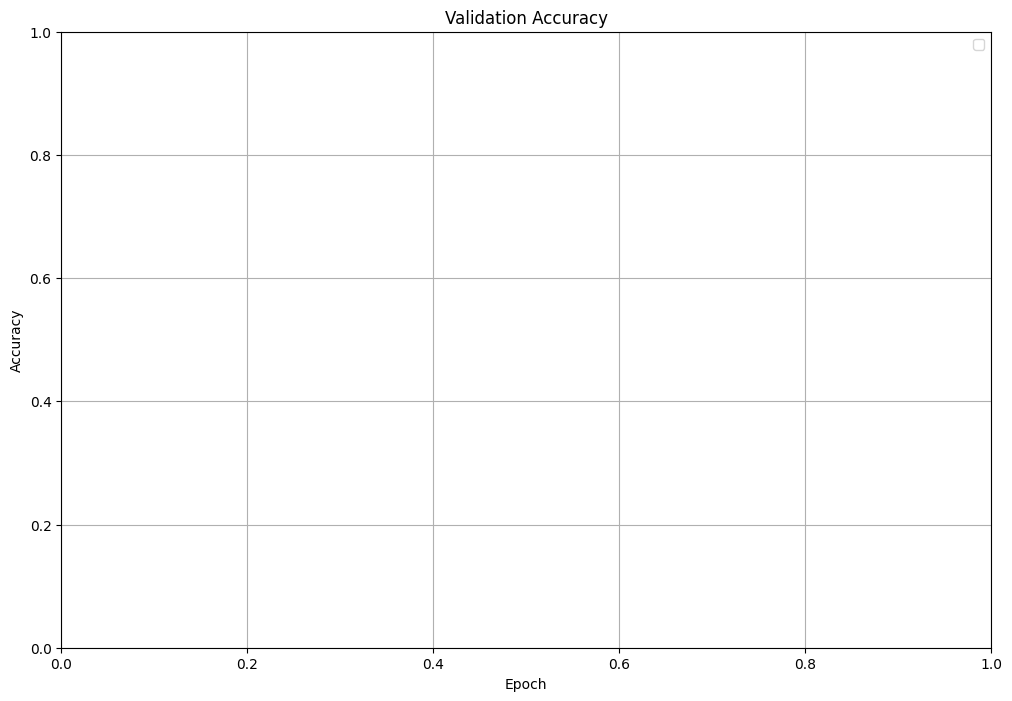

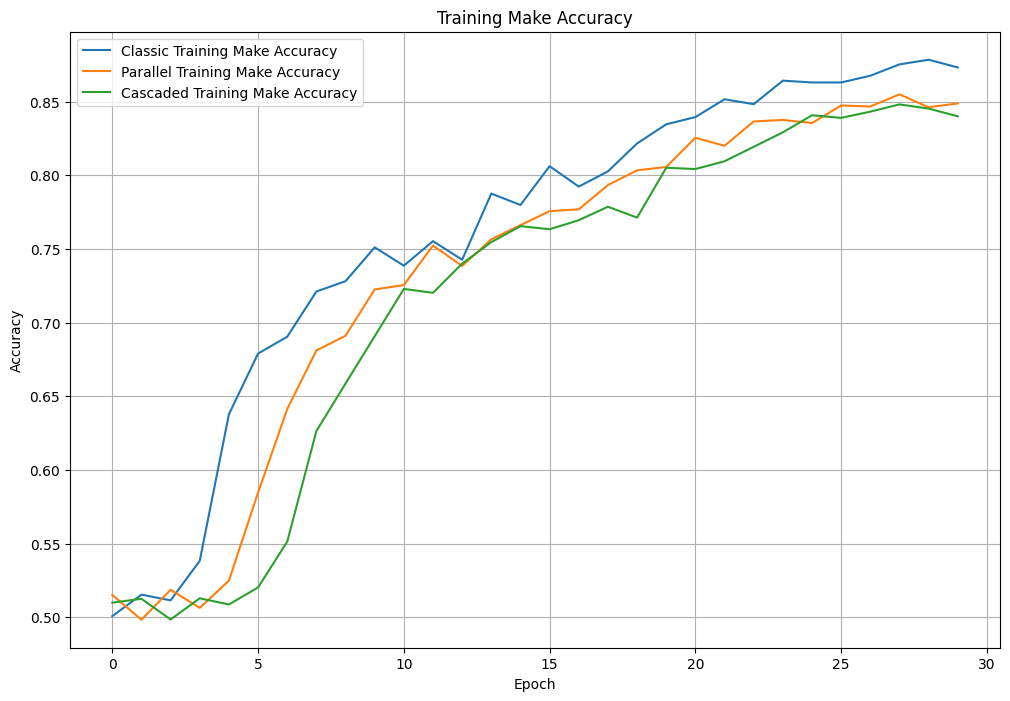

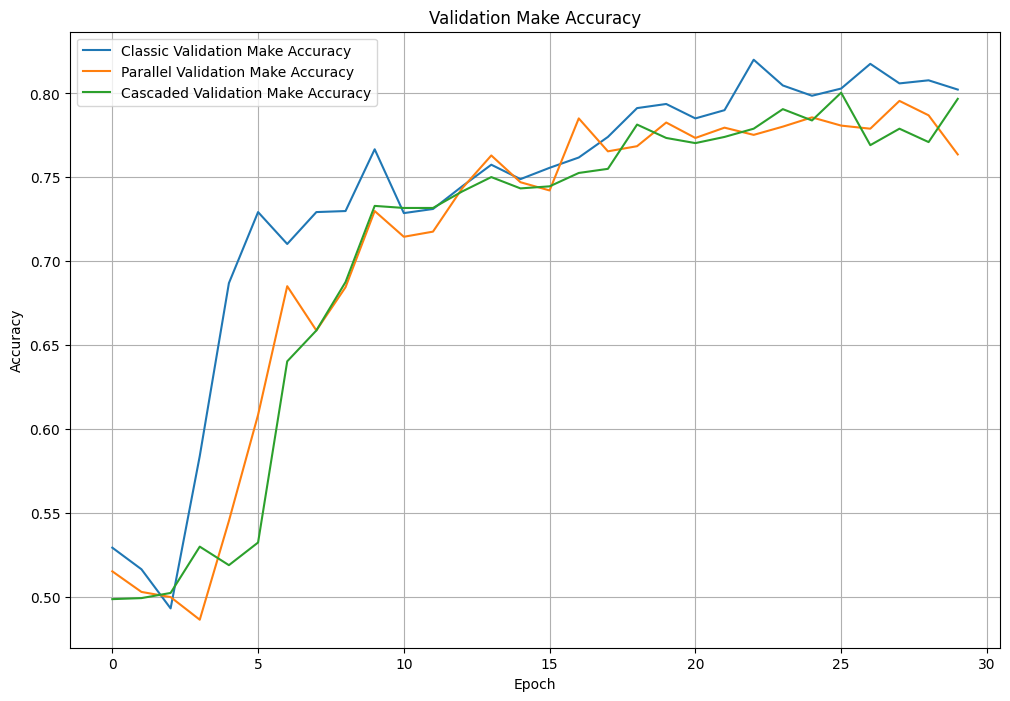

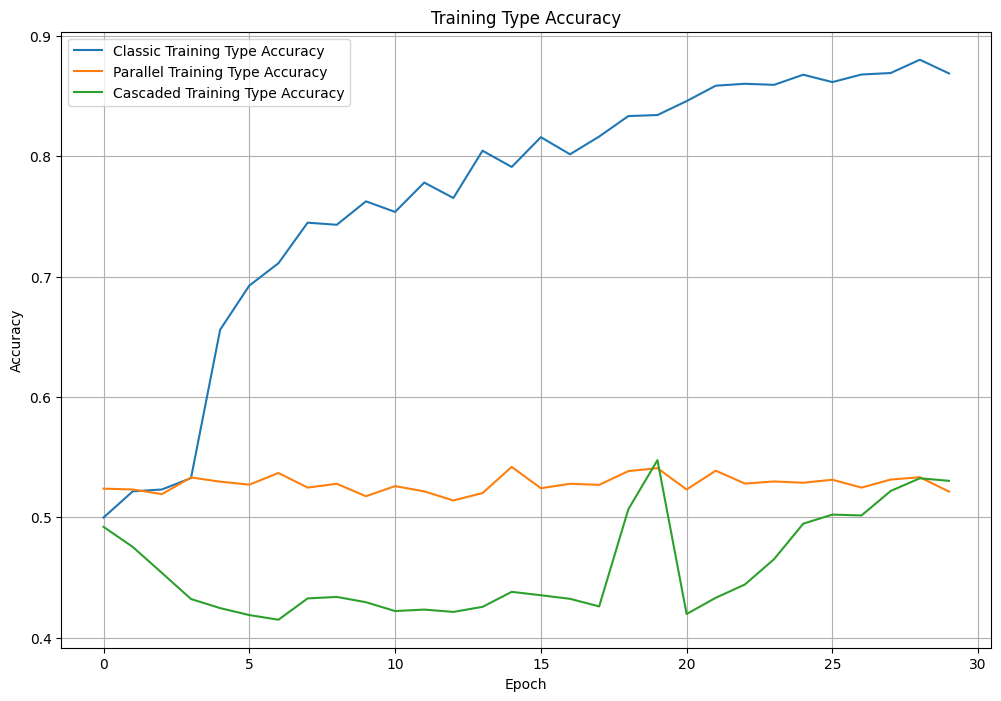

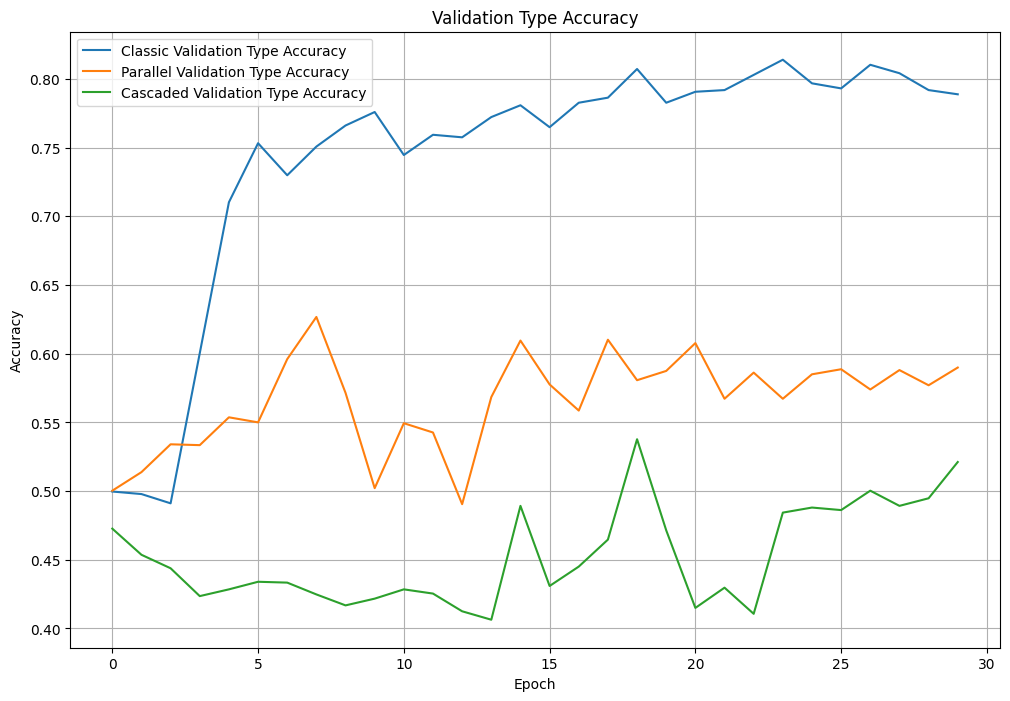

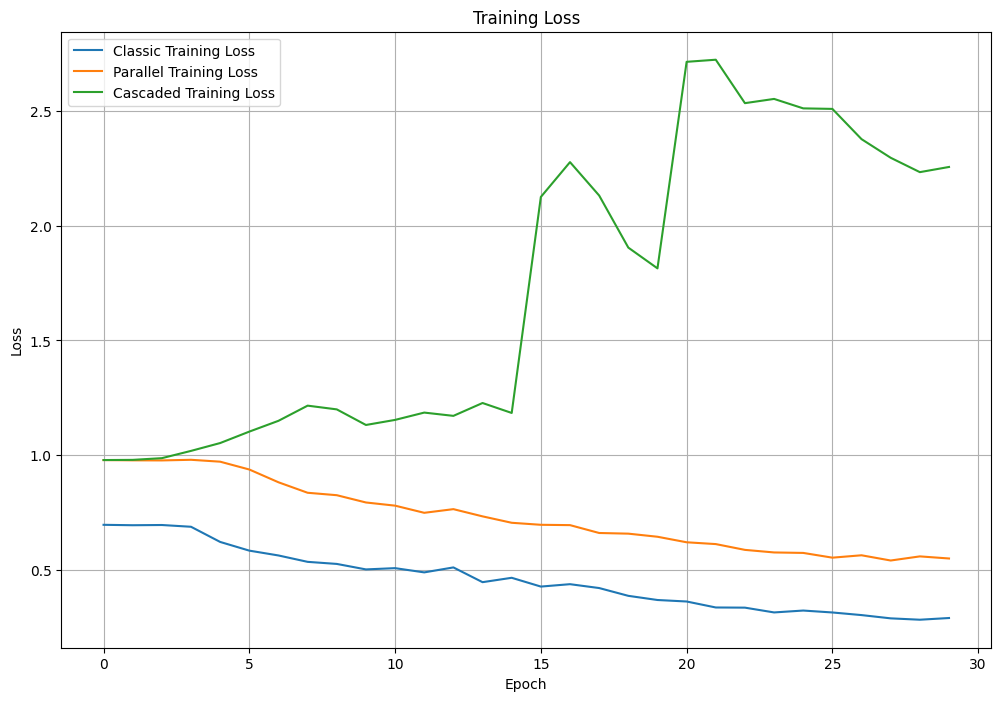

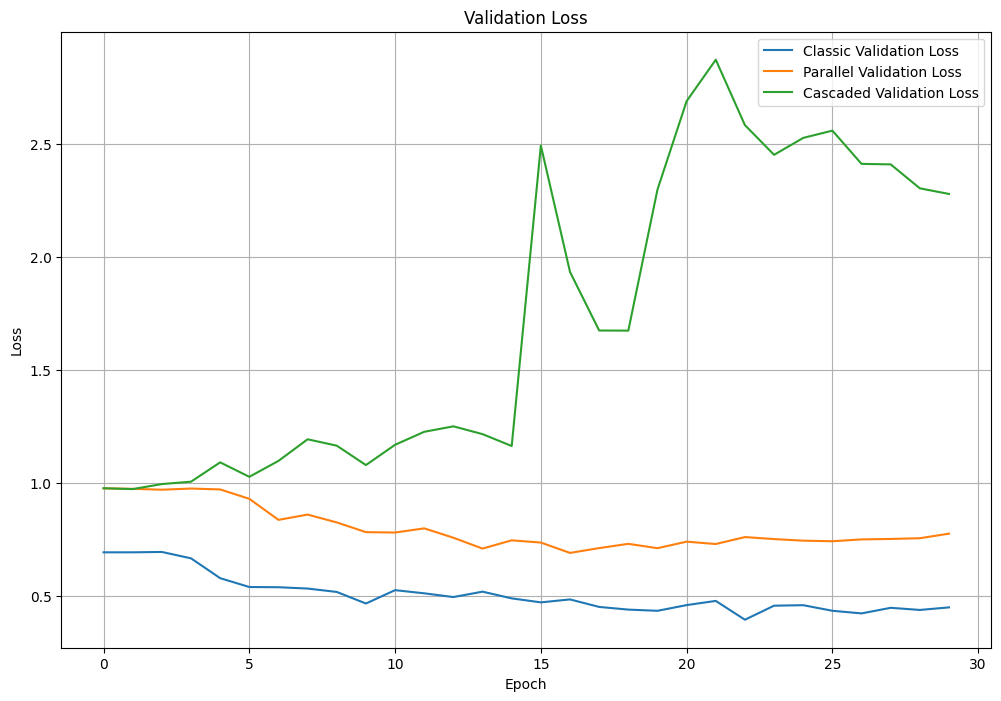

In [ ]:
import os
import matplotlib.pyplot as plt

# Assuming you have these history dictionaries from your training sessions
# Each dictionary should contain lists like 'train_acc', 'val_acc', 'train_loss', 'val_loss'

# List of histories and labels for the plot
histories = [
    ('Classic', classic_history),
    # ('Hierarchic', hierarchic_history),
    ('Parallel', parallel_history),
    ('Cascaded', cascaded_history)
]

# Function to create a folder and save the plot
def save_plot(history_key, title, ylabel, save_path):
    # Create the directory if it doesn't exist

    # Plot the metric for each model
    plt.figure(figsize=(12, 8))
    for label, history in histories:
      if history_key in history:
        plt.plot(history[history_key], label=f'{label} {title}')

    plt.title(title)
    plt.xlabel('Epoch')
    plt.ylabel(ylabel)
    plt.legend(loc='best')
    plt.grid(True)

    # Save the plot to the specified path
    plt.savefig(save_path)

    # Optionally, show the plot (you can comment this out if you don't want to display it)
    plt.show()

# Define the base directory where you want to save the plots

# Save plots for each metric
save_plot('train_acc', 'Training Accuracy', 'Accuracy', os.path.join(BASE_DIR, 'training_accuracy.png'))
save_plot('val_acc', 'Validation Accuracy', 'Accuracy', os.path.join(BASE_DIR, 'validation_accuracy.png'))
save_plot('train_make_acc', 'Training Make Accuracy', 'Accuracy', os.path.join(BASE_DIR, 'training_accuracy_make.png'))
save_plot('val_make_acc', 'Validation Make Accuracy', 'Accuracy', os.path.join(BASE_DIR, 'validation_accuracy_make.png'))
save_plot('train_type_acc', 'Training Type Accuracy', 'Accuracy', os.path.join(BASE_DIR, 'training_accuracy_type.png'))
save_plot('val_type_acc', 'Validation Type Accuracy', 'Accuracy', os.path.join(BASE_DIR, 'validation_accuracy_type.png'))
save_plot('train_loss', 'Training Loss', 'Loss', os.path.join(BASE_DIR, 'training_loss.png'))
save_plot('val_loss', 'Validation Loss', 'Loss', os.path.join(BASE_DIR, 'validation_loss.png'))

In [ ]:
with open(os.path.join(BASE_DIR, "history_classic.json"), "w") as f:
    json.dump(classic_history, f)

with open(os.path.join(BASE_DIR, "history_parallel.json"), "w") as f:
    json.dump(parallel_history, f)

with open(os.path.join(BASE_DIR, "history_cascaded.json"), "w") as f:
    json.dump(cascaded_history, f)

# Test

In [ ]:
optimizer = optim.Adam(trained_classic_model.parameters(), lr=LR)

_, classic_history = train_siamese_mobilenet(
    model=trained_classic_model,
    dataloaders={'train': train_loader_classic, 'val': val_loader_clasic, 'test':test_loader_clasic},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=1,
    device=DEVICE,  # or 'cpu' if you don't have a GPU
    phases = ['test']
)


classic_accuracy = classic_history['test_model_acc']
classic_superclass_accuracy = classic_history['test_make_acc']
classic_type_accuracy = classic_history['test_type_acc']

optimizer = optim.Adam(trained_parallel_model.parameters(), lr=LR)

_, parallel_history = train_parallel_siamese_mobilenet(
    model=trained_parallel_model,
    dataloaders={'train': train_loader_classic, 'val': val_loader_clasic, 'test':test_loader_clasic},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=1,
    device=DEVICE,  # or 'cpu' if you don't have a GPU
    phases = ['test']
)

parallel_accuracy = parallel_history['test_model_acc']
parallel_superclass_accuracy = parallel_history['test_make_acc']
parallel_type_accuracy = parallel_history['test_type_acc']

optimizer = optim.Adam(trained_cascaded_model.parameters(), lr=LR)

_, cascaded_history = train_cascaded_siamese_mobilenet(
    model=trained_cascaded_model,
    dataloaders={'train': train_loader_classic, 'val': val_loader_clasic, 'test':test_loader_clasic},
    criterion=criterion,
    optimizer=optimizer,
    num_epochs=1,
    device=DEVICE,  # or 'cpu' if you don't have a GPU
    phases = ['test']
)

cascaded_accuracy = cascaded_history['test_model_acc']
cascaded_superclass_accuracy = cascaded_history['test_make_acc']
cascaded_type_accuracy = cascaded_history['test_type_acc']

In [ ]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Classic Accuracy', 'Parallel Accuracy', 'Cascaded Accuracy']

values = [classic_accuracy[0], parallel_accuracy[0], cascaded_accuracy[0]]

# Create a bar plot
plt.bar(categories, values)

# Add titles and labels
plt.title('Test Accuracy')
plt.xlabel('Method')
plt.ylabel('Accuracy')

for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

plt.savefig(os.path.join(BASE_DIR, 'test_accuracy.png'))

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Classic Acc.', 'Parallel Acc.', 'Cascaded Acc.']

values = [classic_superclass_accuracy[0], parallel_superclass_accuracy[0], cascaded_superclass_accuracy[0]]

# Create a bar plot
plt.bar(categories, values)

# Add titles and labels
plt.title('Test Make Accuracy')
plt.xlabel('Method')
plt.ylabel('Accuracy')

for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

plt.savefig(os.path.join(BASE_DIR, 'test_make_accuracy.png'))

plt.show()

In [ ]:
import matplotlib.pyplot as plt

# Sample data
categories = ['Classic Acc.', 'Parallel Acc.', 'Cascaded Acc.']

values = [classic_type_accuracy[0], parallel_type_accuracy[0], cascaded_type_accuracy[0]]

# Create a bar plot
plt.bar(categories, values)

# Add titles and labels
plt.title('Test Type Accuracy')
plt.xlabel('Method')
plt.ylabel('Accuracy')

for i, value in enumerate(values):
    plt.text(i, value + 0.01, f'{value:.3f}', ha='center', va='bottom')

plt.savefig(os.path.join(BASE_DIR, 'test_type_accuracy.png'))

plt.show()

In [ ]:
from google.colab import runtime
runtime.unassign()